Looks like ISM is degenerate with Lya profile for the low velocity profile. Make a Chi-square grid?

In [1]:
import numpy as np
from lyapy import lyapy
from lyapy.fitting import *
from scipy.io import readsav
import time
from lyapy import lya_plot
from astropy.modeling.models import Voigt1D
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import astropy.io.fits as pyfits
plt.ion()

import os
import glob
from astropy.table import Table
from astropy.io import ascii

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


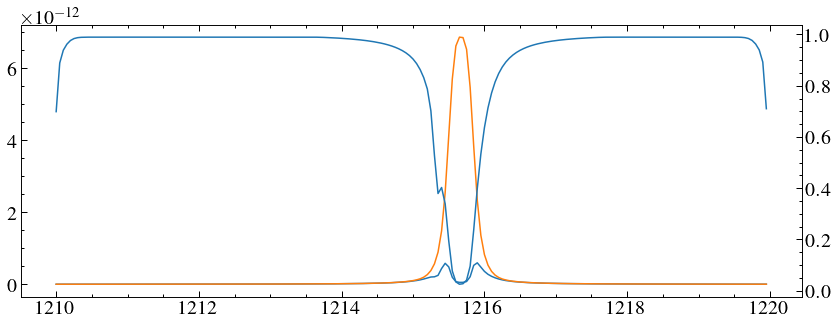

In [2]:
def my_model(wave_lya, resolution, parameters): 
    vs, am, fw_L, fw_G,  \
    h1_col, h1_b, h1_vel, h1_col2, h1_b2, h1_vel2, h1_col3, h1_b3, h1_vel3, d2h, p = parameters
    resolution_lya = lyapy.ready_stis_lsf(resolution[0],resolution[1],wave_lya[1]-wave_lya[0],wave_lya)
    line_center = vs/3e5*1215.67+1215.67
    sigma_G = fw_G/3e5 * 1215.67 
    sigma_L = fw_L/3e5 * 1215.67 
                                           
    voigt_profile_func = Voigt1D(x_0 = line_center, amplitude_L = 10**am, 
                                                fwhm_L = sigma_L, fwhm_G = sigma_G)
    rev_profile = np.exp(-p * voigt_profile_func(wave_lya) / np.max(voigt_profile_func(wave_lya)))
    lya_intrinsic_profile = voigt_profile_func(wave_lya) * rev_profile 
    total_attenuation = lyapy.total_tau_profile_func(wave_lya,
                                               h1_col,h1_b,h1_vel,d2h)
    total_attenuation2 = lyapy.total_tau_profile_func(wave_lya,
                                           h1_col2,h1_b2,h1_vel2,d2h)
    total_attenuation3 = lyapy.total_tau_profile_func(wave_lya,
                                           h1_col3,h1_b3,h1_vel3,d2h)
    ism_profile_convolved = np.convolve(total_attenuation*total_attenuation2*total_attenuation3, resolution_lya, mode='same')
    y_model_lya = lya_intrinsic_profile * total_attenuation * total_attenuation2 * total_attenuation3
    y_model_lya_convolved = np.convolve(y_model_lya, resolution_lya, mode='same')
    lya_intrinsic_profile_convolved = np.convolve(lya_intrinsic_profile, resolution_lya, mode='same')
    return y_model_lya_convolved, lya_intrinsic_profile_convolved, ism_profile_convolved
lsf_filename = 'LSF_G140M_1200.txt'
lsf = np.loadtxt(lsf_filename,skiprows=2) # 52x0.1 G140M - confirmed from MAST
lsf_wave = lsf[:,0]
lsf_array = lsf[:,1]
resolution = [lsf_wave,lsf_array]
wave = np.arange(1210, 1220, 0.05)
parameters = [0, -10, 10, 50, 18.0, 11.5, 0, 0, 11.5, 0, 0, 11.5, 0, 1.5e-5, 1.2]
#vs, am, fw_L, fw_G,  h1_col, h1_b, h1_vel, h1_col2, h1_b2, h1_vel2, h1_col3, h1_b3, h1_vel3, d2h, p
model, intrinsic, ism = my_model(wave, resolution, parameters)
plt.figure()
plt.plot(wave, model)
plt.plot(wave, intrinsic)
plt.twinx()
plt.plot(wave, ism)

In [3]:
path = '/media/david/2tb_ext_hd/hddata/eg_uma/lya_results/'

data = Table.read('{}oehua2010_SR_nosmearing_MCMC_results.csv'.format(path))

In [4]:
data.dtype.names

('col0',
 'lya_model_low_2sig',
 'lya_model_low_1sig',
 'lya_model_median',
 'lya_model_high_1sig',
 'lya_model_high_2sig',
 'lya_intrinsic_low_2sig',
 'lya_intrinsic_low_1sig',
 'lya_intrinsic_median',
 'lya_intrinsic_high_1sig',
 'lya_intrinsic_high_2sig',
 'lya_ism_low_2sig',
 'lya_ism_low_1sig',
 'lya_ism_median',
 'lya_ism_high_1sig',
 'lya_ism_high_2sig',
 'lya_reversal_low_2sig',
 'lya_reversal_low_1sig',
 'lya_reversal_median',
 'lya_reversal_high_1sig',
 'lya_reversal_high_2sig',
 'lya_intrinsic_fluxes',
 'vs_n value',
 'am_n value',
 'fw_L_n value',
 'fw_G_n value',
 'h1_col value',
 'h1_b value',
 'h1_vel value',
 'h1_col2 value',
 'h1_b2 value',
 'h1_vel2 value',
 'h1_col3 value',
 'h1_b3 value',
 'h1_vel3 value',
 'd2h value',
 'p value',
 'wave_lya',
 'flux_lya',
 'error_lya')

In [5]:
# parameters = [0, -10, 10, 50, 18.0, 11.5, 0, 0, 11.5, 0, 0, 11.5, 0, 1.5e-5, 1.2]
#vs, am, fw_L, fw_G,  h1_col, h1_b, h1_vel, h1_col2, h1_b2, h1_vel2, h1_col3, h1_b3, h1_vel3, d2h, p
parameters = [data['vs_n value'][2], data['am_n value'][2], data['fw_L_n value'][2], data['fw_G_n value'][2], data['h1_col value'][2], 11.5,0,0,
              data['h1_vel value'][2],0,0,11.5,0,1.5e-5, data['p value'][2]]


model, intrinsic, ism = my_model(wave, resolution, parameters)

-12.33297238002551
17.339108218905977


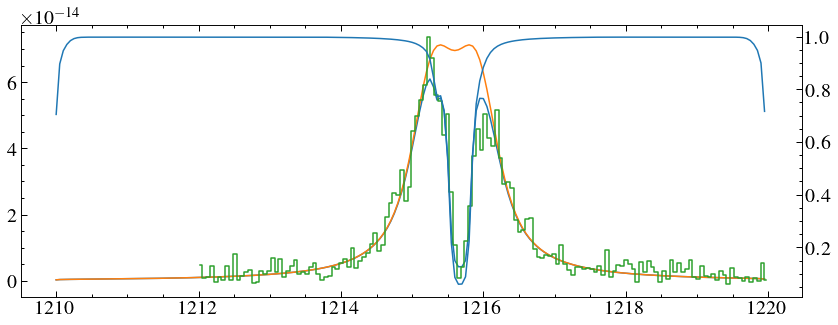

In [6]:
plt.figure()
plt.plot(wave, model)
plt.plot(wave, intrinsic)
plt.step(data['wave_lya'], data['flux_lya'], where='mid')

plt.twinx()
plt.plot(wave, ism)
print(parameters[1])
print(parameters[4])

In [7]:
#individual fit
print(data['am_n value'][2], data['h1_col value'][2])
# simfit
simdata = Table.read('{}allfour_SR_RVvaryonly_MCMC_results.csv'.format(path))
print(simdata['am value'][2], simdata['h1_col value'][2])

print(data['am_n value'][2]-data['h1_col value'][2])
print(simdata['am value'][2]-simdata['h1_col value'][2])


-12.33297238002551 17.339108218905977
-11.85325195514032 18.032425446038474
-29.672080598931487
-29.885677401178796


In [8]:

w, f = data['wave_lya'], data['flux_lya']

In [9]:
from scipy.stats import chisquare

In [67]:
path = '/media/david/2tb_ext_hd/hddata/eg_uma/lya_results/'

data = Table.read('{}oehua2010_SR_nosmearing_MCMC_results.csv'.format(path))


ngrid = 100
amp_range = np.arange(-11.5, -13.05, -0.05)
ism_range = np.arange(14, 19.05, 0.05)
chi_grid = np.ndarray(shape=(len(amp_range), len(ism_range)),dtype=float)
# print(amp_range)
# print(ism_range)

w, f, e = data['wave_lya'], data['flux_lya'], data['error_lya']

parameters = [data['vs_n value'][2], data['am_n value'][2], data['fw_L_n value'][2], data['fw_G_n value'][2], data['h1_col value'][2], 11.5,0,0,
              data['h1_vel value'][2],0,0,11.5,0,1.5e-5, data['p value'][2]]

lsf_filename = 'LSF_G140M_1200.txt'
lsf = np.loadtxt(lsf_filename,skiprows=2) # 52x0.1 G140M - confirmed from MAST
lsf_wave = lsf[:,0]
lsf_array = lsf[:,1]
resolution = [lsf_wave,lsf_array]

amp_out = []
ism_out = []
chi_out = []

for i in range(len(amp_range)):
    for j in range(len(ism_range)):
        parameters[1] = amp_range[i]
        parameters[4] = ism_range[j]
        # print(parameters[1])
        model, intrinsic, ism = my_model(w, resolution, parameters)
        rchi2 = np.sum(((f-model)**2)/(e**2)) / (len(f) -2)
        chi_grid[i, j] = rchi2
        amp_out.append(amp_range[i])
        ism_out.append(ism_range[j])
        chi_out.append(rchi2)
#         plt.figure()
#         plt.plot(w, model)
#         plt.plot(w, intrinsic)
#         plt.step(data['wave_lya'], data['flux_lya'], where='mid')

#         plt.twinx()
#         plt.plot(w, ism)
#         plt.show()
   


In [70]:
results = Table([amp_out, ism_out, np.array(chi_out)], names=['Amplitude', 'NH', 'Chi2'])
ascii.write(results, 'chi2_results.ecsv', format='ecsv', overwrite=True)

In [58]:
np.save('chi_grid',chi_grid)

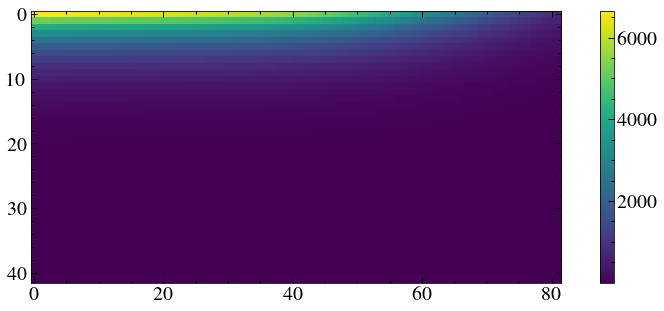

In [59]:
plt.imshow(chi_grid)
plt.colorbar()

In [60]:
import seaborn as sns


<AxesSubplot:>

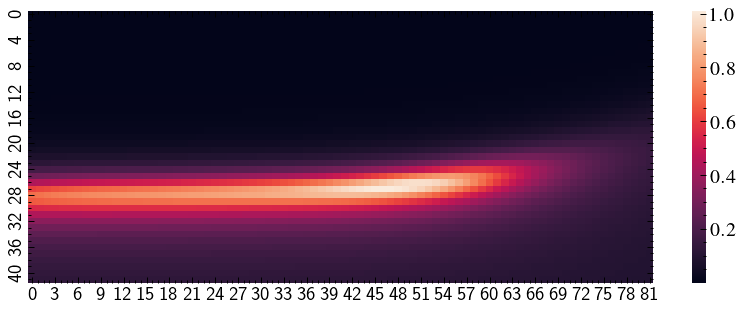

In [61]:
sns.heatmap(1/chi_grid)

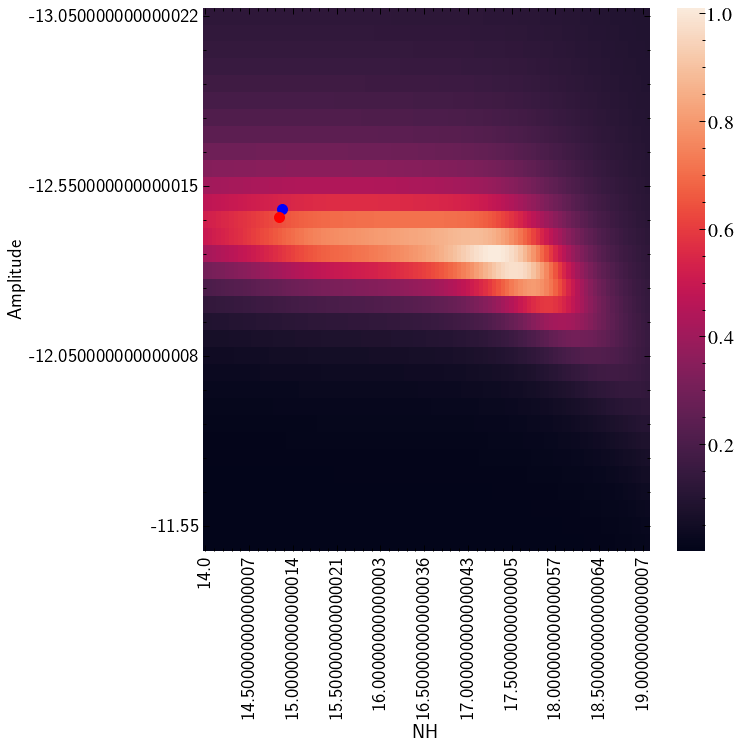

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))

resmap = results.to_pandas()

# map = sns.load
resmap = resmap.pivot('Amplitude', 'NH', 'Chi2')

ax = sns.heatmap(1/resmap, xticklabels=10,  yticklabels=10)

# plt.axvline(simdata['h1_col value'][2], c='C1')
# plt.axvline(data['h1_col value'][2])
# plt.axhline(simdata['am value'][2], c='C1')
# print(simdata['am value'][2])
# plt.axhline(data['am_n value'][2], c='C0')
# ax.scatter(simdata['h1_col value'][2], -1*simdata['am value'][2], c='b', s=100)
# ax.scatter(data['h1_col value'][2], -1*data['am_n value'][2], c='r', s=100)
# print(data['am_n value'][2]-data['h1_col value'][2])
# print(simdata['am value'][2]-simdata['h1_col value'][2])
# plt.xticks((15.5, 16, 16.5, 17, 17.5))
# ax.set_ylim(-12.1, -13.1)
